# Анализ данных развлекательного приложения: выявление причин убытков и определение точек роста

# Описание проекта

Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. Задача — разобраться в причинах и помочь компании выйти в плюс.  

Для решения задачи предстоит изучить:  

•	откуда приходят пользователи и какими устройствами они пользуются  
•	сколько стоит привлечение пользователей из различных рекламных каналов  
•	сколько денег приносит каждый клиент  
•	когда расходы на привлечение клиента окупаются  
•	какие факторы мешают привлечению клиентов  

# Цель проекта

Выявить причины возникновения убытков и сформулировать рекомендации для отдела маркетинга.


# Описание данных

*Датасет visits_info_short.csv* (Лог сервера с информацией о посещениях сайта)  

**User Id** — уникальный идентификатор пользователя  
**Region** — страна пользователя  
**Device** — тип устройства пользователя  
**Channel** — идентификатор источника перехода  
**Session Start** — дата и время начала сессии  
**Session End** — дата и время окончания сессии     

*Датасет orders_info_short.csv* (Информация о заказах)   

**User Id** — уникальный идентификатор пользователя  
**Event Dt** — дата и время покупки  
**Revenue** — сумма заказа   

*Датасет costs_info_short.csv* (Информация о расходах на рекламу)  

**dt** — дата проведения рекламной кампании  
**Channel** — идентификатор рекламного источника  
**costs** — расходы на эту кампанию  

# Содержание

**1 Загрузка и подготовка данных**    
1.1 Импорт библиотек и загрузка данных  
1.2 Обзор и предобработка данных  
1.3 Вывод  
**2 Функции для расчёта и анализа LTV, ROI, удержания и конверсии**  
2.1 Функции для вычисления значений метрик  
2.2 Функции для построения графиков  
2.3 Вывод  
**3 Исследовательский анализ данных**  
3.1 Составление профилей пользователей и определение минимальной и максимальной даты привлечения  
3.2 Анализ пользователей по странам  
3.3 Анализ пользователей по устройствам  
3.4 Анализ пользователей по рекламным источникам привлечения  
3.5 Вывод  
**4 Маркетинг**  
4.1 Общая сумма расходов на маркетинг  
4.2 Распределение затрат по рекламным источникам  
4.3 Визуализация динамики изменения расходов во времени  
4.4 Стоимость привлечения одного пользователя (CAC) из каждого источника  
4.5 Вывод  
**5 Оценка окупаемости рекламы**  
5.1 Анализ окупаемости рекламы  
5.2 Окупаемость рекламы с разбивкой по устройствам  
5.3 Окупаемость рекламы с разбивкой по странам  
5.4 Окупаемость рекламы с разбивкой по рекламным каналам  
5.5 Динамика конверсии и удержания пользователей  
5.6 Вывод и рекомендации для рекламного отдела  
**6 Выводы**  

## 1 Загрузка и подготовка данных

### 1.1 Импорт библиотек и загрузка данных

Импортируем библиотеки:

In [59]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

Загружаем данные и сохраняем их в соответствующих переменных:

In [60]:
visits = pd.read_csv('/datasets/visits_info_short.csv')
orders = pd.read_csv('/datasets/orders_info_short.csv')
costs = pd.read_csv('/datasets/costs_info_short.csv')

### 1.2 Обзор и предобработка данных

Выводим первые 5 строк и общую информацию таблицы **visits**:

In [61]:
display(visits.head())
visits.info()

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


Обзор данных таблицы visits выявил проблемы стиля в названиях столбцов (используются буквы верхнего регистра и пробелы) и неверный тип данных в столбцах с датой и временем (**Session Start**, **Session End**). Проведем необходимую предобработку:

In [62]:
# приводим названия столбцов к нижнему регистру и меняем пробел на подчеркивание:
visits.columns = [x.lower().replace(' ', '_') for x in visits.columns] 

visits.columns  # контролируем результат

Index(['user_id', 'region', 'device', 'channel', 'session_start',
       'session_end'],
      dtype='object')

In [63]:
visits['session_start'] = pd.to_datetime(visits['session_start']) # меняем тип данных на datetime64
visits['session_end'] = pd.to_datetime(visits['session_end'])
visits.info()  # контролируем результат

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


Теперь выведем первые 5 строк и общую информацию таблицы **orders**:

In [64]:
display(orders.head())
orders.info()

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


Здесь также присутствуют проблемы стиля в заголовках и неверный тип данных в столбце с датой и временем **Event Dt**. Проведем аналогичную предобработку:

In [65]:
# приводим названия столбцов к нижнему регистру и меняем пробел на подчеркивание:
orders.columns = [x.lower().replace(' ', '_') for x in orders.columns]  

orders.columns  # контролируем результат

Index(['user_id', 'event_dt', 'revenue'], dtype='object')

In [66]:
orders['event_dt'] = pd.to_datetime(orders['event_dt']) # меняем тип данных на datetime64
orders.info()  # контролируем результат

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB


Аналогичным образом проверяем таблицу **costs**:

In [67]:
display(costs.head())
costs.info()

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


Здесь наблюдаем те же пролемы в данных, поэтому проведем предобработку привычным способом:

In [68]:
# приводим названия столбцов к нижнему регистру и меняем пробел на подчеркивание:
costs.columns = [x.lower().replace(' ', '_') for x in costs.columns]

costs.columns  # контролируем результат

Index(['dt', 'channel', 'costs'], dtype='object')

In [69]:
costs['dt'] = pd.to_datetime(costs['dt']).dt.date # извлекаем дату

В завершение предобработки, проверим данные на наличие дубликатов:

In [70]:
print(visits.duplicated().sum())
print(orders.duplicated().sum())
print(costs.duplicated().sum())

0
0
0


Дубликатов нет.

### 1.3 Вывод

Во всех трех датасетах отсутствуют пропуски и дубликаты, в то же время выявлены однотипные нарушения стиля при именовании заголовков, а также несоответствие типа данных в столбцах с датой и временем. Необходимая предобработка проведена, данные готовы для дальнейшей работы над проектом.

## 2 Функции для расчёта и анализа LTV, ROI, удержания и конверсии

### 2.1 Функции для вычисления значений метрик

Для упрощения вычесления значений метрик подготовим соответсвующие функции:

**get_profiles()** — для создания профилей пользователей

In [71]:
def get_profiles(sessions, orders, ad_costs):
    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )
    
    # для когортного анализа определяем дату первого посещения, номер недели и первый день месяца, в котором это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['week'] = profiles['first_ts'].dt.isocalendar().week  
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
    
    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )
    
    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')
    
    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']
    
    # добавляем в профили стоимость привлечения
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )
    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles    

**get_retention()** — для подсчёта Retention Rate

In [72]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):
    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days=horizon_days - 1)
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

**get_conversion()** — для подсчёта конверсии

In [73]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):
    
    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )
    
    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

**get_ltv_roi()** — для подсчёта LTV и ROI

In [74]:
def get_ltv_roi(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):
    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC и ROI в лайфтаймах, не превышающих горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

### 2.2 Функции для построения графиков

Для построения однотипных графиков также подготовим соответствующие функции:

**filter_data()** — для сглаживания данных

In [75]:
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

**plot_retention()** — для построения графика Retention Rate

In [76]:
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer, добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    plt.tight_layout()
    plt.show() 

**plot_conversion()** — для построения графика конверсии

In [78]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

**plot_ltv_roi()** — для визуализации LTV и ROI

In [79]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[[horizon - 1]]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

### 2.3 Вывод

Все функции, необходимые для проведения расчётов и анализа LTV, ROI, удержания и конверсии, заданы. Можно приступать к следующему разделу - исследовательскому анализу даных.

## 3 Исследовательский анализ данных

### 3.1 Составление профилей пользователей и определение минимальной и максимальной даты привлечения

In [80]:
profiles = get_profiles(visits, orders, costs)  # получаем профили пользователей
profiles.head()  # контролируем результат

,user_id,first_ts,channel,device,region,dt,week,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,19,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,28,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,40,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,34,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,40,2019-10-01,False,0.230769


In [81]:
print('Минимальная дата привлечения пользователей: ', profiles['first_ts'].min())  # определяем минимальную дату привлечения 
print('Максимальная дата привлечения пользователей:', profiles['first_ts'].max())  # определяем максимальную дату привлечения

Минимальная дата привлечения пользователей:  2019-05-01 00:00:41
Максимальная дата привлечения пользователей: 2019-10-27 23:59:04


### 3.2 Анализ пользователей по странам

In [82]:
users_by_region = profiles.groupby('region').agg({'user_id': 'nunique', 'payer': ['sum', 'mean']}) # группируем пользователей
users_by_region.columns = ['всего пользователей', 'в т.ч. платящих', 'доля платящих']  # назначаем названия столбцов
users_by_region.sort_values(by='доля платящих', ascending=False).style.format({'доля платящих': '{:.2%}'}) # сортируем и выводим

,всего пользователей,в т.ч. платящих,доля платящих
region,,,
United States,100002,6902,6.90%
Germany,14981,616,4.11%
UK,17575,700,3.98%
France,17450,663,3.80%


Пользователи приложения приходят из четырех стран: США, Великобритания, Франция и Германия. Наибольшее количество платящих пользователей приходится на США.

### 3.3 Анализ пользователей по устройствам

In [83]:
users_by_device = profiles.groupby('device').agg({'user_id': 'nunique', 'payer': ['sum', 'mean']}) # группируем пользователей
users_by_device.columns = ['всего пользователей', 'в т.ч. платящих', 'доля платящих']  # назначаем названия столбцов
users_by_device.sort_values(by='доля платящих', ascending=False).style.format({'доля платящих': '{:.2%}'}) # сортируем и выводим

,всего пользователей,в т.ч. платящих,доля платящих
device,,,
Mac,30042,1912,6.36%
iPhone,54479,3382,6.21%
Android,35032,2050,5.85%
PC,30455,1537,5.05%


Пользователи используют следующие типы устройств: iPhone, Android, PC и Mac. Наибольшее количество платящих пользователей используют Mac. На втором месте - пользователи iPhone, т.е. пользователи продукции Apple среди платящих клиентов составляют более 50%, что не удивительно, поскольку продукция Apple находится в более высоком ценовом сегменте.

### 3.4 Анализ пользователей по рекламным источникам привлечения

In [84]:
users_by_channel = profiles.groupby('channel').agg({'user_id': 'nunique', 'payer': ['sum', 'mean']}) # группируем пользователей
users_by_channel.columns = ['всего пользователей', 'в т.ч. платящих', 'доля платящих']  # назначаем названия столбцов
users_by_channel.sort_values(by='доля платящих', ascending=False).style.format({'доля платящих': '{:.2%}'}) # выводим результат

,всего пользователей,в т.ч. платящих,доля платящих
channel,,,
FaceBoom,29144,3557,12.20%
AdNonSense,3880,440,11.34%
lambdaMediaAds,2149,225,10.47%
TipTop,19561,1878,9.60%
RocketSuperAds,4448,352,7.91%
WahooNetBanner,8553,453,5.30%
YRabbit,4312,165,3.83%
MediaTornado,4364,156,3.57%
LeapBob,8553,262,3.06%


Наибольшее количество пользователей - органические. В качестве рекламных источников используются следующие: FaceBoom, TipTop, OppleCreativeMedia, WahooNetBanner, LeapBob, RocketSuperAds, MediaTornado, YRabbit, AdNonSense и lambdaMediaAds. Наибольшее количество платящих пользователей получено от FaceBoom. Среди лидеров по генерации платежеспособных пользователей можно также отметить  AdNonSense, lambdaMediaAds и TipTop.

### 3.5 Вывод

На этапе исследовательского анализа данных установлено следующее:  
- Минимальная дата привлечения пользователей 01.05.2019г., максимальная дата - 27.10.2019г.  
- Максимальное кол-во пользователей сосредоточено в США, и наибольшее количество платящих пользователей также приходится на США - 6,9%. 
- Наибольшее кол-во пользователей используют iPhone, среди платящих пользователей лидируют устройства Mac - 6,36% и iPhone - 6,21%, т.е. продукция Apple.   
- Наибольшее количество пользователей - органические, а лучшая рекламная площадка по привлечению платежеспособных клиентов - FaceBoom - 12,2%. Среди лидеров по привлечению платящих клиентов также можно отметить AdNonSense - 11,34%, lambdaMediaAds - 10,47% и TipTop - 9,6%.

## 4. Маркетинг

### 4.1 Общая сумма расходов на маркетинг

Для подсчета общей суммы расходов на маркетинг применим к столбцу **costs** (одноименной таблицы) метод `.sum()` 

In [85]:
total_cost = costs['costs'].sum().round(2) # считаем сумму расходов, округляем и сохраняем в отдельной переменной
print('Общая сумма расходов на маркетинг:', total_cost)  # выводим результат

Общая сумма расходов на маркетинг: 105497.3


### 4.2 Распределение затрат по рекламным источникам

Сгруппируем суммы затрат столбца **acquisition_cost** по рекламным источникам **столбца channel** и визуализируем результат:

,сумма затрат,процент затрат
channel,,
TipTop,54751.30,51.90
FaceBoom,32445.60,30.75
WahooNetBanner,5151.00,4.88
AdNonSense,3911.25,3.71
OppleCreativeMedia,2151.25,2.04
RocketSuperAds,1833.00,1.74
LeapBob,1797.60,1.70
lambdaMediaAds,1557.60,1.48
MediaTornado,954.48,0.90


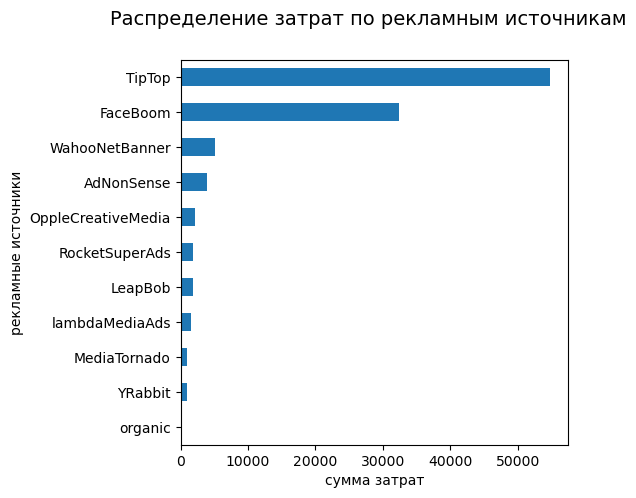

In [86]:
cost_by_channel = profiles.groupby('channel').agg({'acquisition_cost': ['sum']})  # группируем данные
cost_by_channel.columns = ['сумма затрат']
cost_by_channel['процент затрат'] = (cost_by_channel['сумма затрат'] / cost_by_channel['сумма затрат'].sum() * 100).round(2)
display(cost_by_channel.sort_values(by='сумма затрат', ascending=False))  # выводим таблицу
cost_by_channel.sort_values(by='сумма затрат').plot(y='сумма затрат', kind='barh', legend=False, figsize=(5, 5)) # визуализируем
plt.suptitle('Распределение затрат по рекламным источникам', size=14)
plt.xlabel('сумма затрат',size=10)
plt.ylabel('рекламные источники')
plt.show()

Самые большие затраты приходятся на два рекламных источника: TipTop и FaceBoom, в сумме они составляют более 80%.

### 4.3 Визуализация динамики изменения расходов во времени

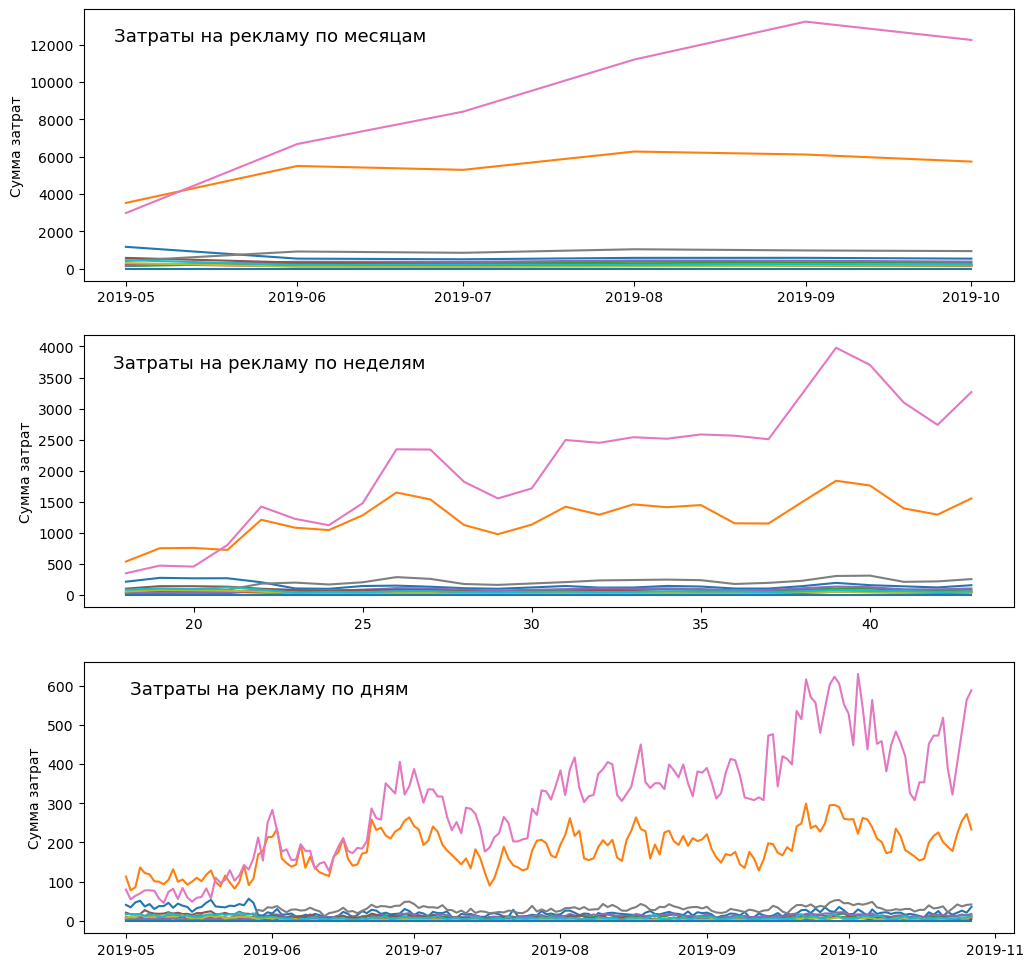

In [87]:
plt.figure(figsize=(12, 12))
ax1 = plt.subplot(3, 1, 1)
plt.plot(profiles.pivot_table(index='month', columns='channel', values='acquisition_cost', aggfunc='sum'))
plt.title('Затраты на рекламу по месяцам', fontsize=13, x=0.2, y=0.85)
plt.ylabel('Сумма затрат')

ax2 = plt.subplot(3, 1, 2)
plt.plot(profiles.pivot_table(index='week', columns='channel', values='acquisition_cost', aggfunc='sum'))
plt.title('Затраты на рекламу по неделям', fontsize=13, x=0.2, y=0.85)
plt.ylabel('Сумма затрат')

ax3 = plt.subplot(3, 1, 3)
plt.plot(profiles.pivot_table(index='dt', columns='channel', values='acquisition_cost', aggfunc='sum'))
plt.title('Затраты на рекламу по дням', fontsize=13, x=0.2, y=0.85)
plt.ylabel('Сумма затрат')
plt.show()

Затраты на рекламу в TipTop и FaceBoom имеют очевидную тенденцию к росту, отмечается также рост затрат к концу месяца и снижение к середине. Вероятнее всего это связано с ежемесячным планированием бюджета, когда к концу месяца осваиваются свободные деньги.

### 4.4 Стоимость привлечения одного пользователя (CAC) из каждого источника

Посчитаем среднее значение CAC для каждого рекламного источника и визуализируем результат:

,acquisition_cost
channel,
TipTop,2.80
FaceBoom,1.11
AdNonSense,1.01
lambdaMediaAds,0.72
WahooNetBanner,0.60
RocketSuperAds,0.41
OppleCreativeMedia,0.25
YRabbit,0.22
MediaTornado,0.22


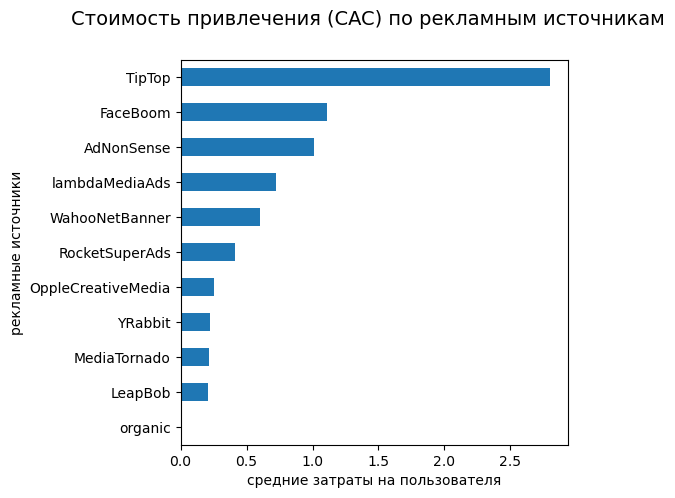

In [88]:
display(profiles.groupby('channel').agg(
    {'acquisition_cost': 'mean'}).sort_values(
    by='acquisition_cost', ascending=False).round(2))

profiles.groupby('channel').agg(
    {'acquisition_cost': 'mean'}).sort_values(
    by='acquisition_cost').plot(y='acquisition_cost',
                                kind='barh',
                                legend=False,
                                figsize=(5, 5))

plt.suptitle('Стоимость привлечения (CAC) по рекламным источникам', size=14)
plt.xlabel('средние затраты на пользователя',size=10)
plt.ylabel('рекламные источники')
plt.show()

Для расчета средней стоимости привлечения по всем источникам, исключим органических пользователей с помощью `query()`:

In [89]:
print('Средняя стоимость привлечения пользователя (CAC) по всем рекламным источникам:',
      round(profiles.query('channel!="organic"')['acquisition_cost'].mean(), 2))

Средняя стоимость привлечения пользователя (CAC) по всем рекламным источникам: 1.13


Самый затратный рекламный источник TipTop - САС = 2,80 при среднем значении 1,13.  
Динамику и эффекивность затрат на привлечение пользователей рассмотрим в разделе 5.

### 4.5 Вывод

Общая сумма расходов на маркетинг составляет 105497.30  
Большая часть расходов приходится на два рекламных источника: TipTop - 54751,30 и FaceBoom - 32445.60, и эти затраты имеют устойчивую тенденцию к росту.  
Также выявлено, что TipTop является самым затратным по стоимости привлечения пользователей - САС = 2,80 при среднем значении 1,13.

## 5 Оценка окупаемости рекламы

### 5.1 Анализ окупаемости рекламы

Для начала исключим из выборки данные по органическим пользователям, поскольку мы будем считать эффективность затрат по конкретным рекламным каналам:

In [90]:
profiles = profiles.query('channel != "organic"')

Теперь установим момент и горизонт анализа:

In [91]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа 

Считаем LTV, ROI и строим графики:

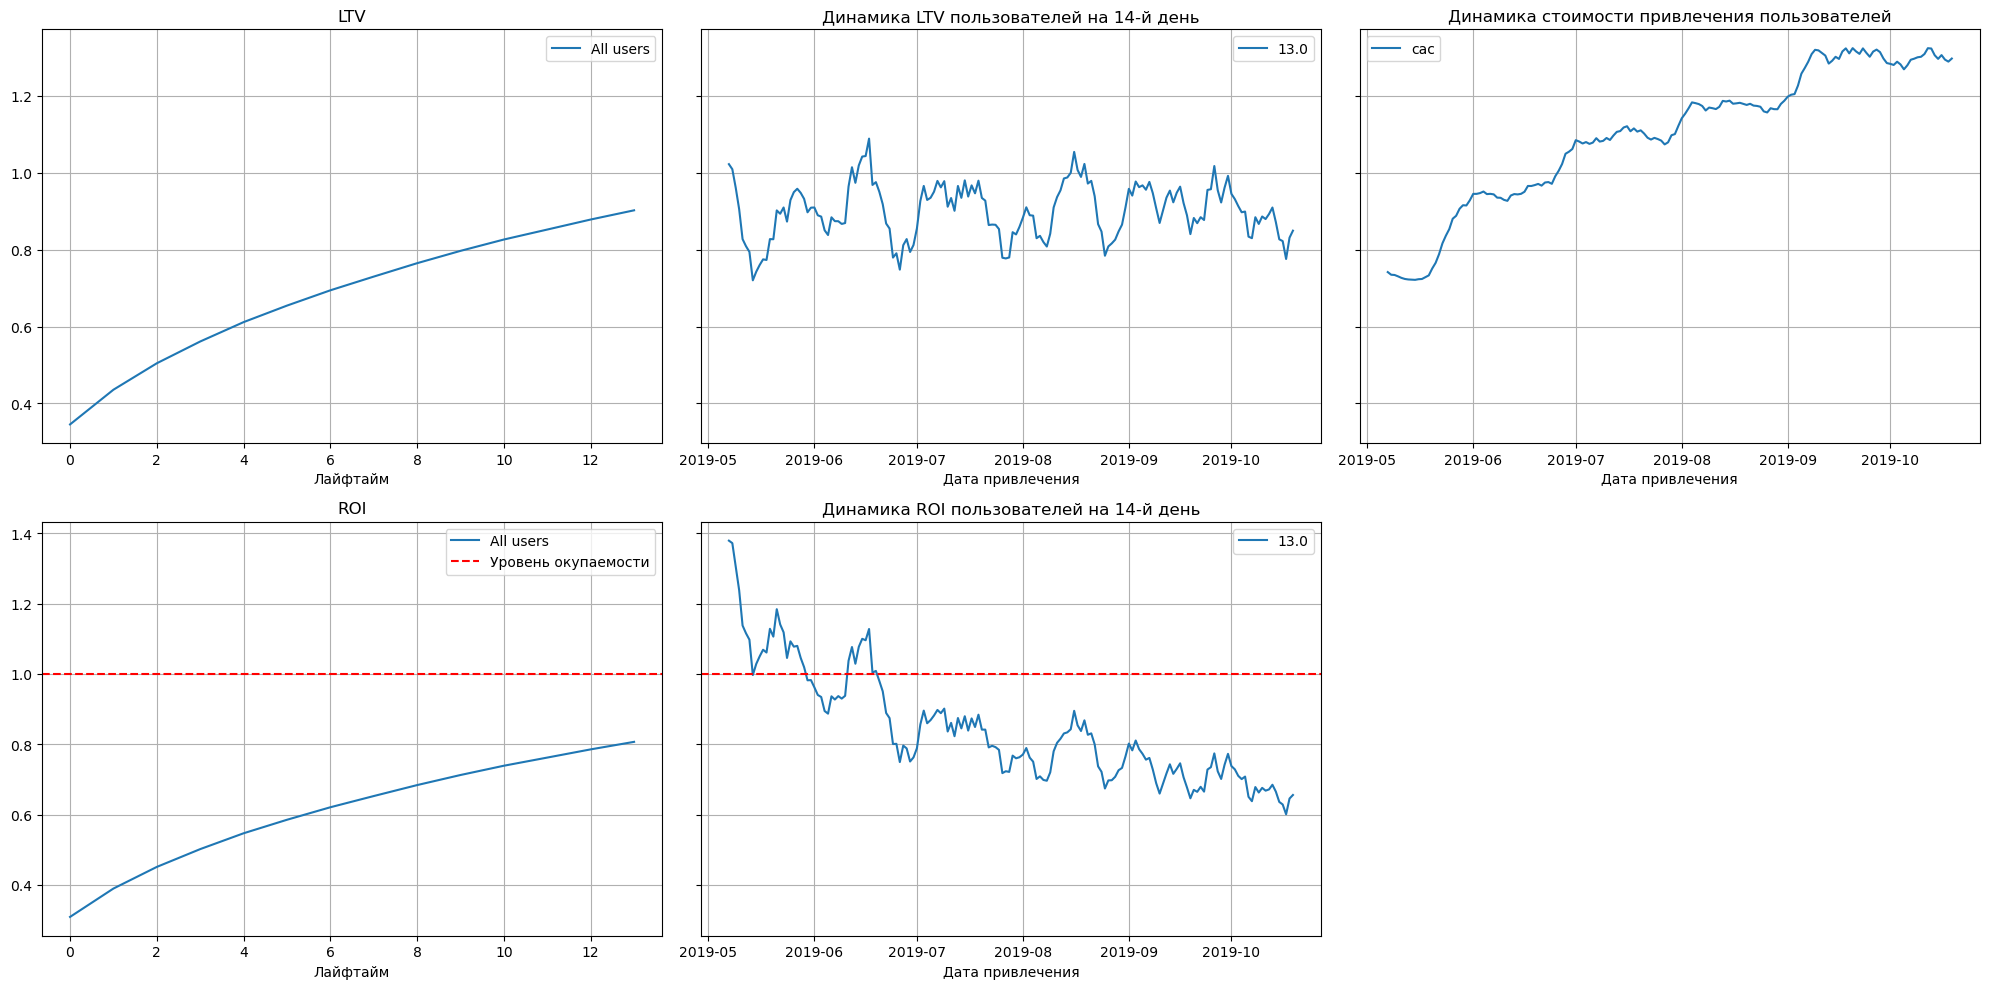

In [92]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv_roi(profiles, orders, observation_date, horizon_days)
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

LTV растет, но вместе с тем, растет и стоимость привлечения пользователей (CAC). А динамика ROI показывает, что затраты на рекламу не окупаются и с каждым месяцем ситуация ухудшается.

### 5.2 Окупаемость рекламы с разбивкой по устройствам

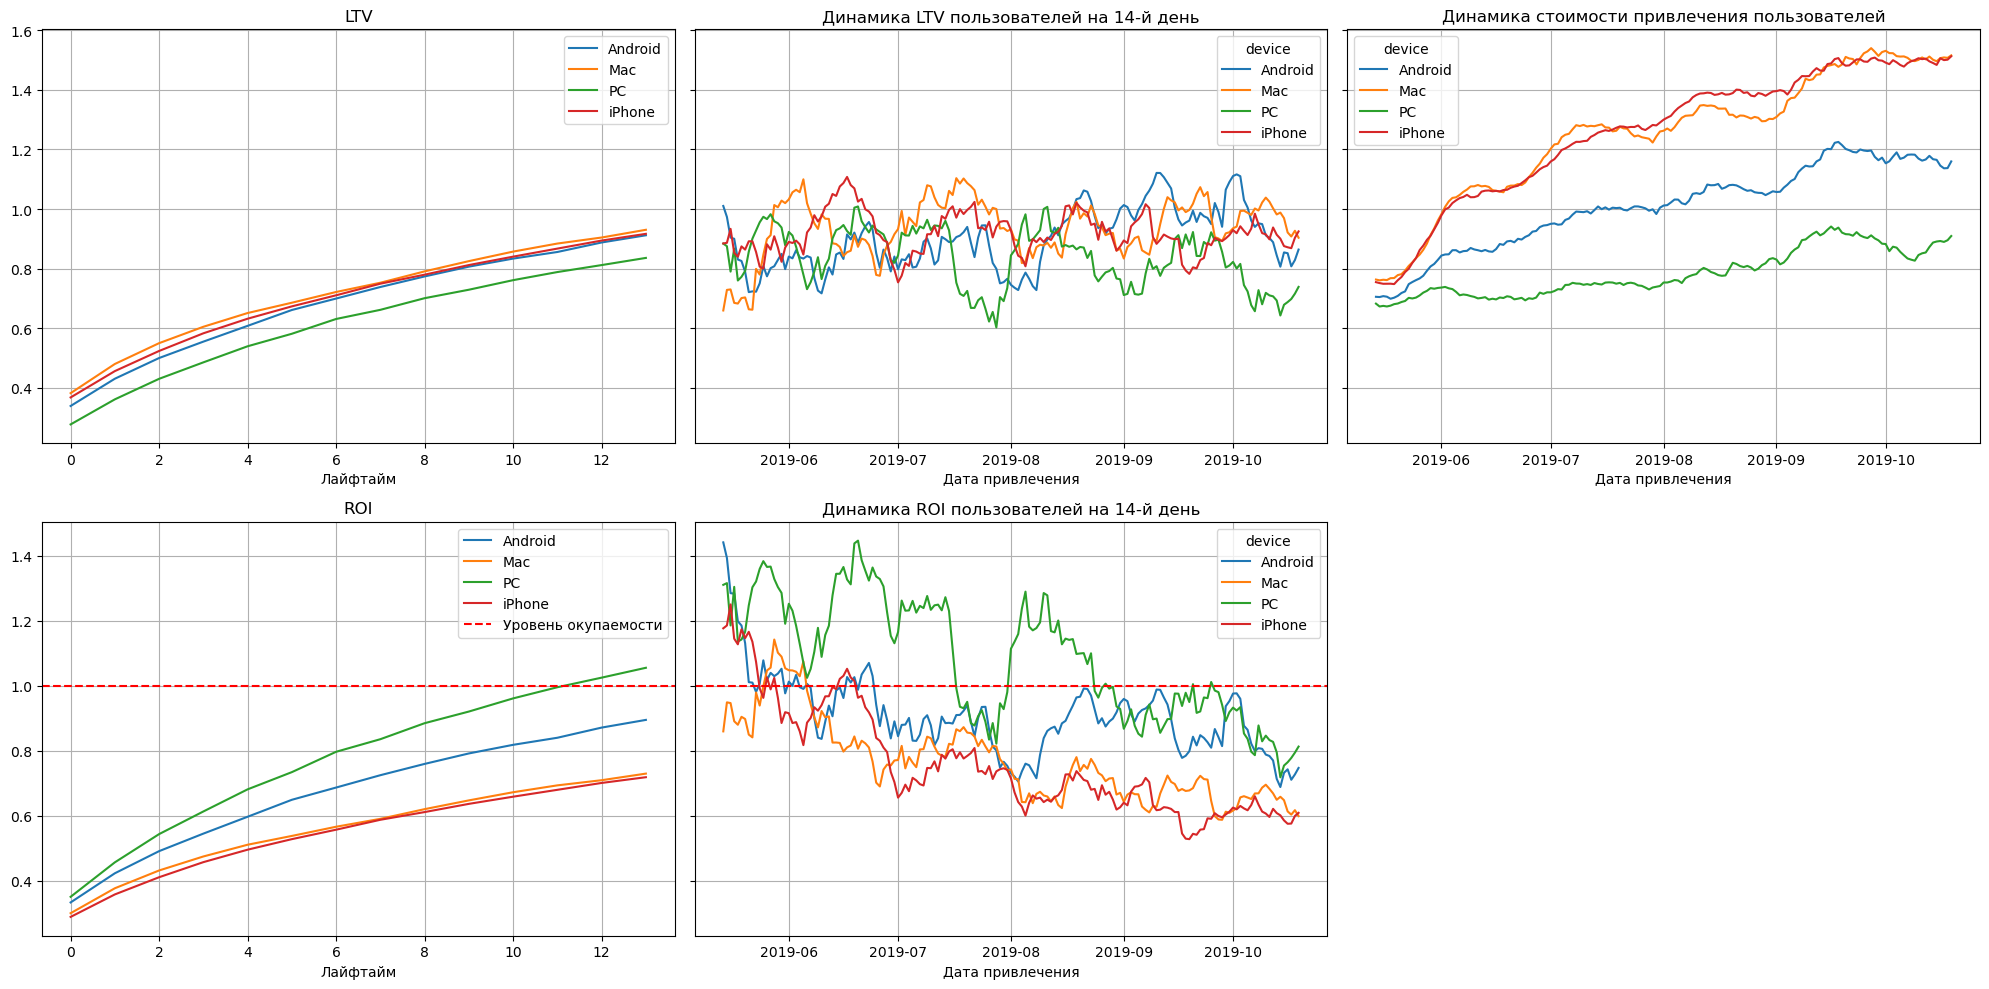

In [93]:
dimensions = ['device']
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv_roi(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)
plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

LTV и САС в течении лайфтайма растут у всех пользователей, но затраты на привлечение пользователей PC растут медленнее, поэтому в рассматриваемом периоде они окупаются в отличии от остальных.

### 5.3 Окупаемость рекламы с разбивкой по странам

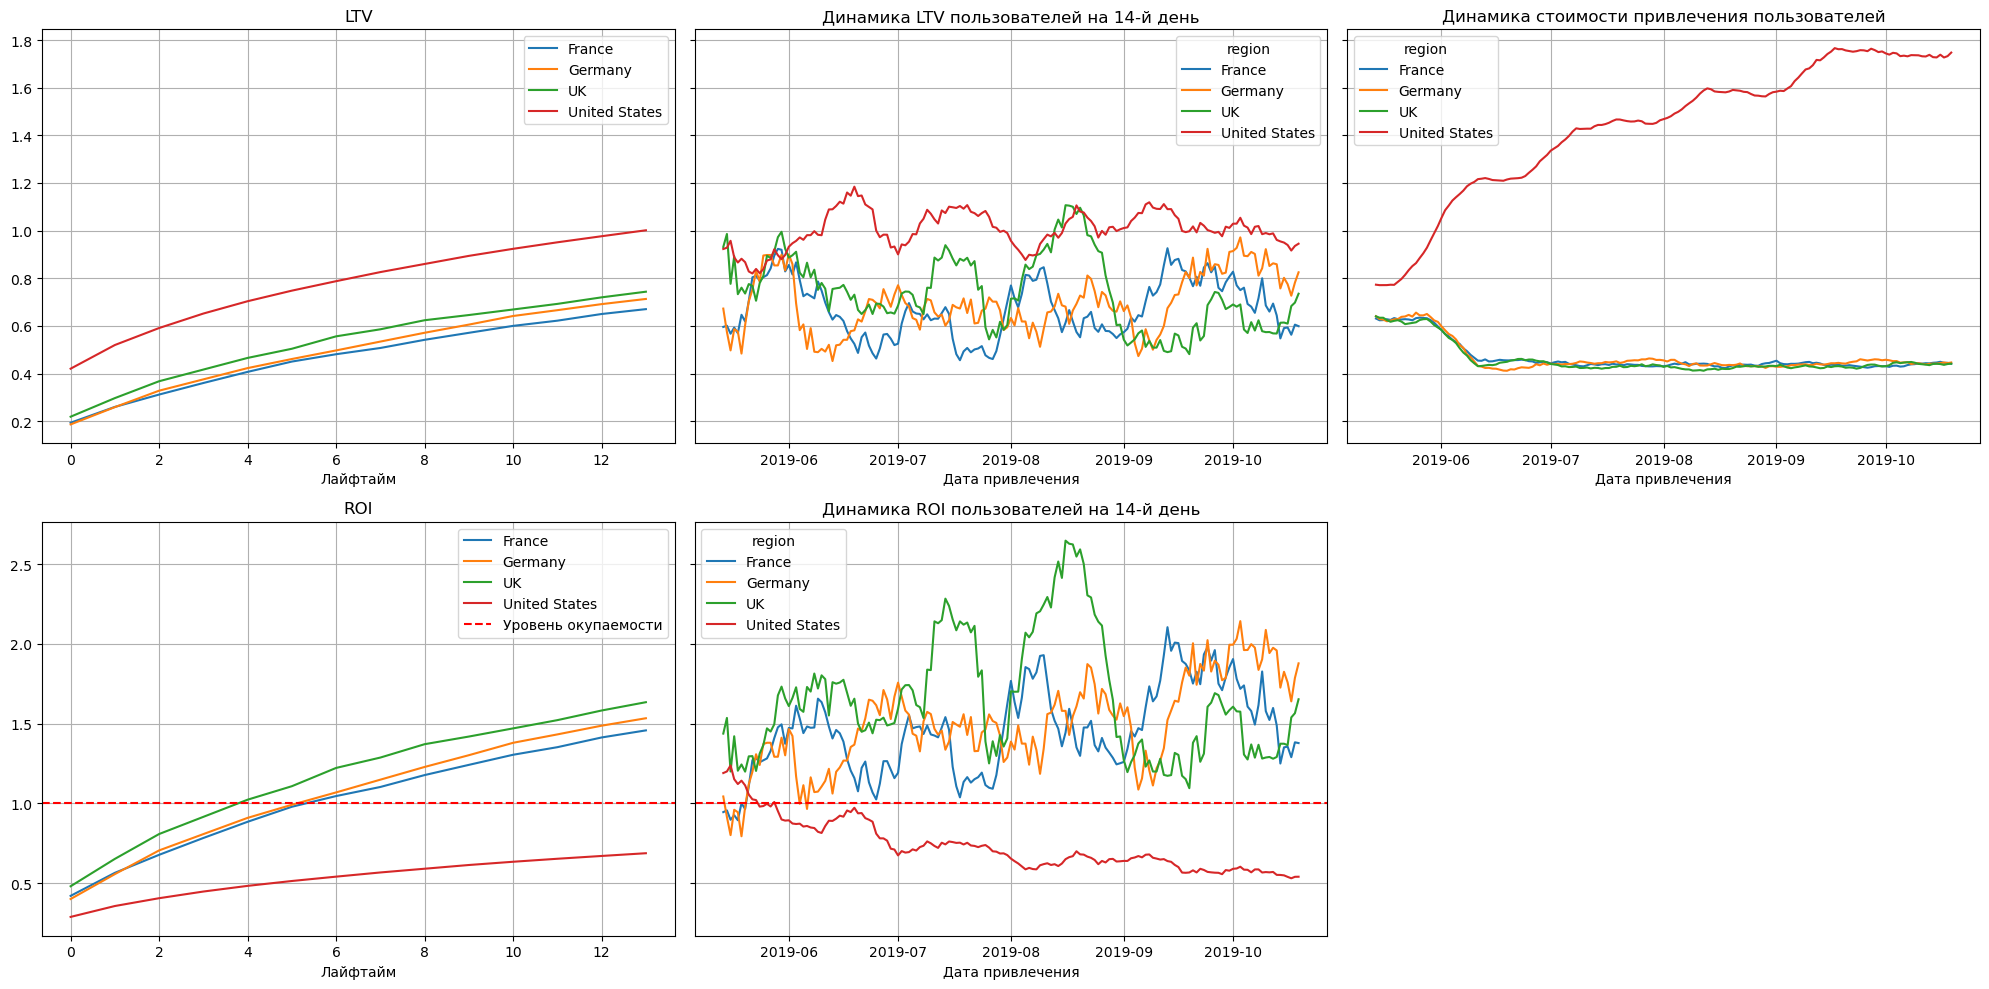

In [94]:
dimensions = ['region']
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv_roi(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)
plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

LTV здесь также растет у всех, лидируют по этому показателю пользователи США, при этом затраты на привлечение пользователей в США растут опережающими темпами, и они явно не оправданы, т.к. динамика ROI этих пользователей интенсивно снижается. В то же время САС по остальным пользователям не растет, благодаря чему затраты на них окупаются.

Посмотрим еще, есть ли особенность использования рекламных каналов по странам:

In [97]:
cost_by_channel_region = profiles.groupby(['region', 'channel']).agg({'acquisition_cost': ['sum']}).round(2)
cost_by_channel_region.columns = ['сумма затрат']
cost_by_channel_region

сумма затрат
region        channel                         
France        AdNonSense               1376.32
              LeapBob                   628.05
              OppleCreativeMedia        747.34
              WahooNetBanner           1789.14
              lambdaMediaAds            535.14
Germany       AdNonSense               1229.28
              LeapBob                   529.95
              OppleCreativeMedia        640.73
              WahooNetBanner           1552.97
              lambdaMediaAds            471.29
UK            AdNonSense               1305.65
              LeapBob                   639.61
              OppleCreativeMedia        763.18
              WahooNetBanner           1808.89
              lambdaMediaAds            551.17
United States FaceBoom                32445.60
              MediaTornado              954.48
              RocketSuperAds           1833.00
              TipTop                  54751.30
              YRabbit                   944.22

Действительно, такая особенность есть. Рекламные каналы, используемые в США - не используются в Европе, и наборот, Европейские каналы не используются в США.

Проведем аналогичную проверку и по используемым устройствам:

In [98]:
cost_by_channel_region = profiles.groupby(['region', 'device']).agg({'acquisition_cost': ['sum']}).round(2)
cost_by_channel_region.columns = ['сумма затрат']
cost_by_channel_region

сумма затрат
region        device               
France        Android       1521.75
              Mac            530.73
              PC            2003.46
              iPhone        1020.03
Germany       Android       1283.67
              Mac            493.51
              PC            1773.97
              iPhone         873.08
UK            Android       1486.48
              Mac            484.69
              PC            2061.80
              iPhone        1035.53
United States Android      18168.73
              Mac          22585.61
              PC            9424.12
              iPhone       40750.15

Здесь мы видим, что охвачены все виды устройств, но есть преобладание затрат на пользователей Мас и iPhone в США, а в Европе - на PC и Android.

### 5.4 Окупаемость рекламы с разбивкой по рекламным каналам

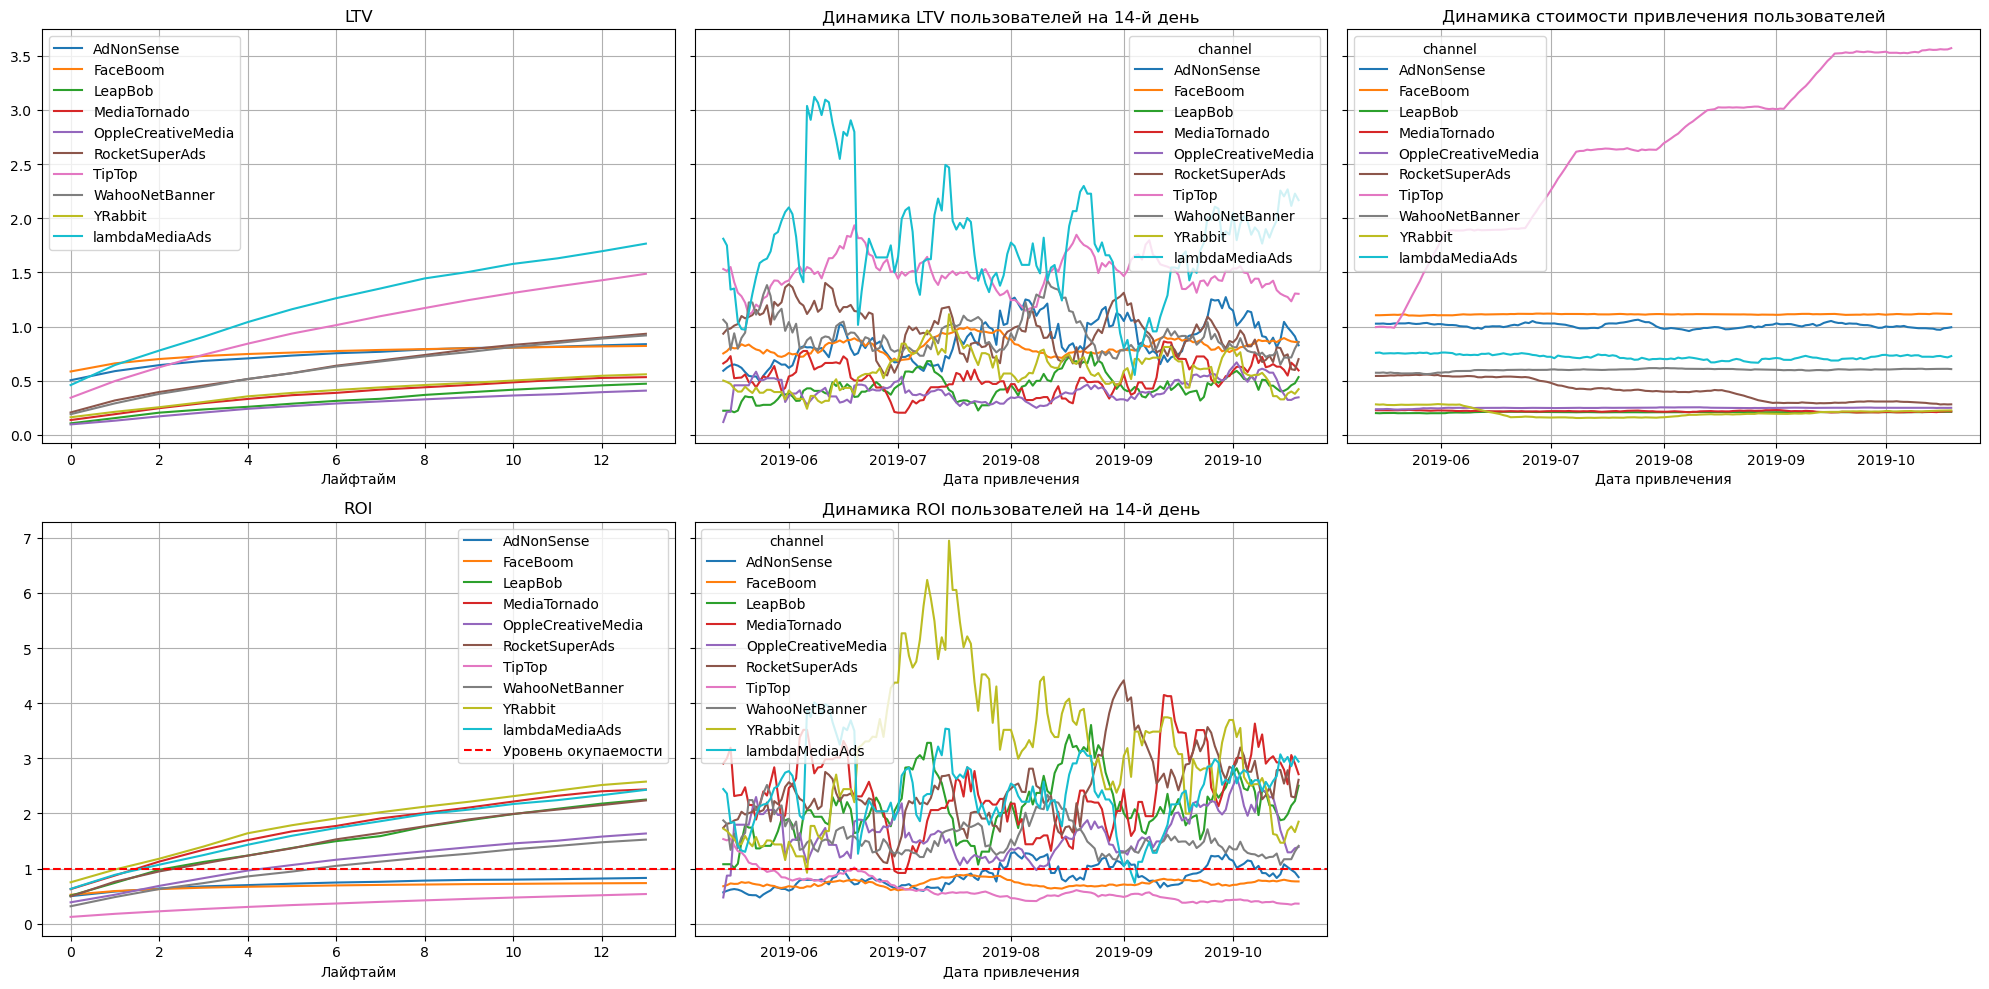

In [99]:
dimensions = ['channel']
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv_roi(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)
plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

LTV здесь также растет у всех, но три источника показывают явную убыточность - TipTop, FaceBoom и AdNonSense. Также, отслеживается ежемесячное увеличение стоимости привлечения пользователей TipTop, этот график имеет очевидное сходство с графиками CAC пользователей из США и пользователей Mac и iPhone.

### 5.5 Динамика конверсии и удержания пользователей

Посчитаем и выведем графики по конверсии и удержанию пользователей с разбивкой по устройствам:

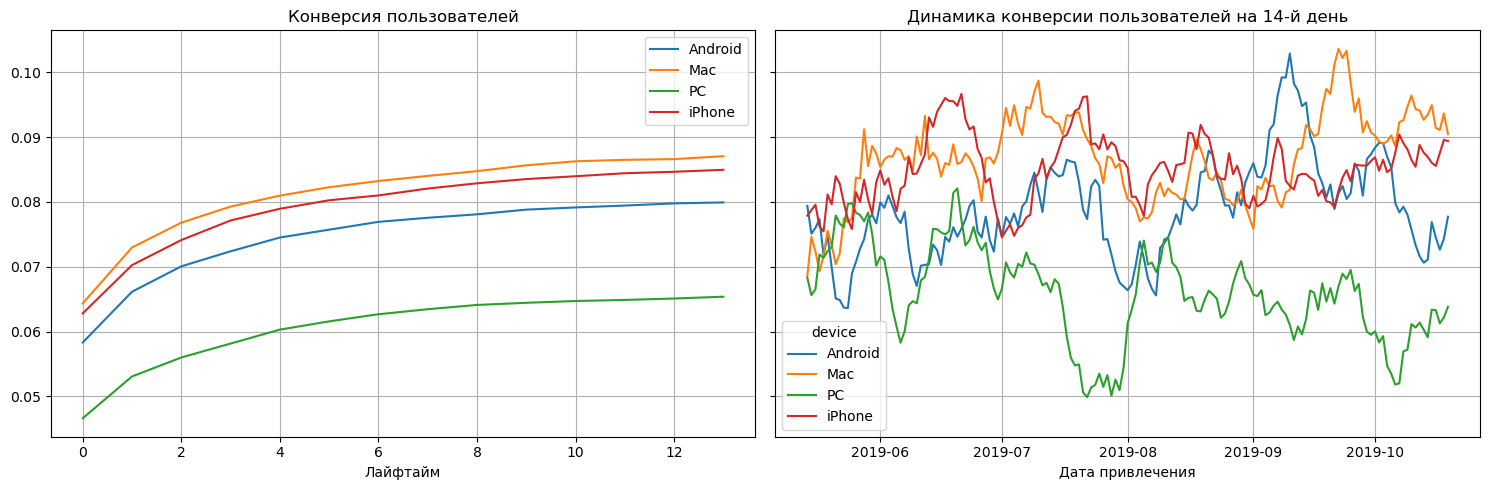

In [100]:
dimensions = ['device']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)
plot_conversion(conversion_grouped, conversion_history, horizon_days, window=14) 

Самая лучшая конверсия наблюдается у пользователей Mac и iPhone, пользователи PC по конверсии отстают.

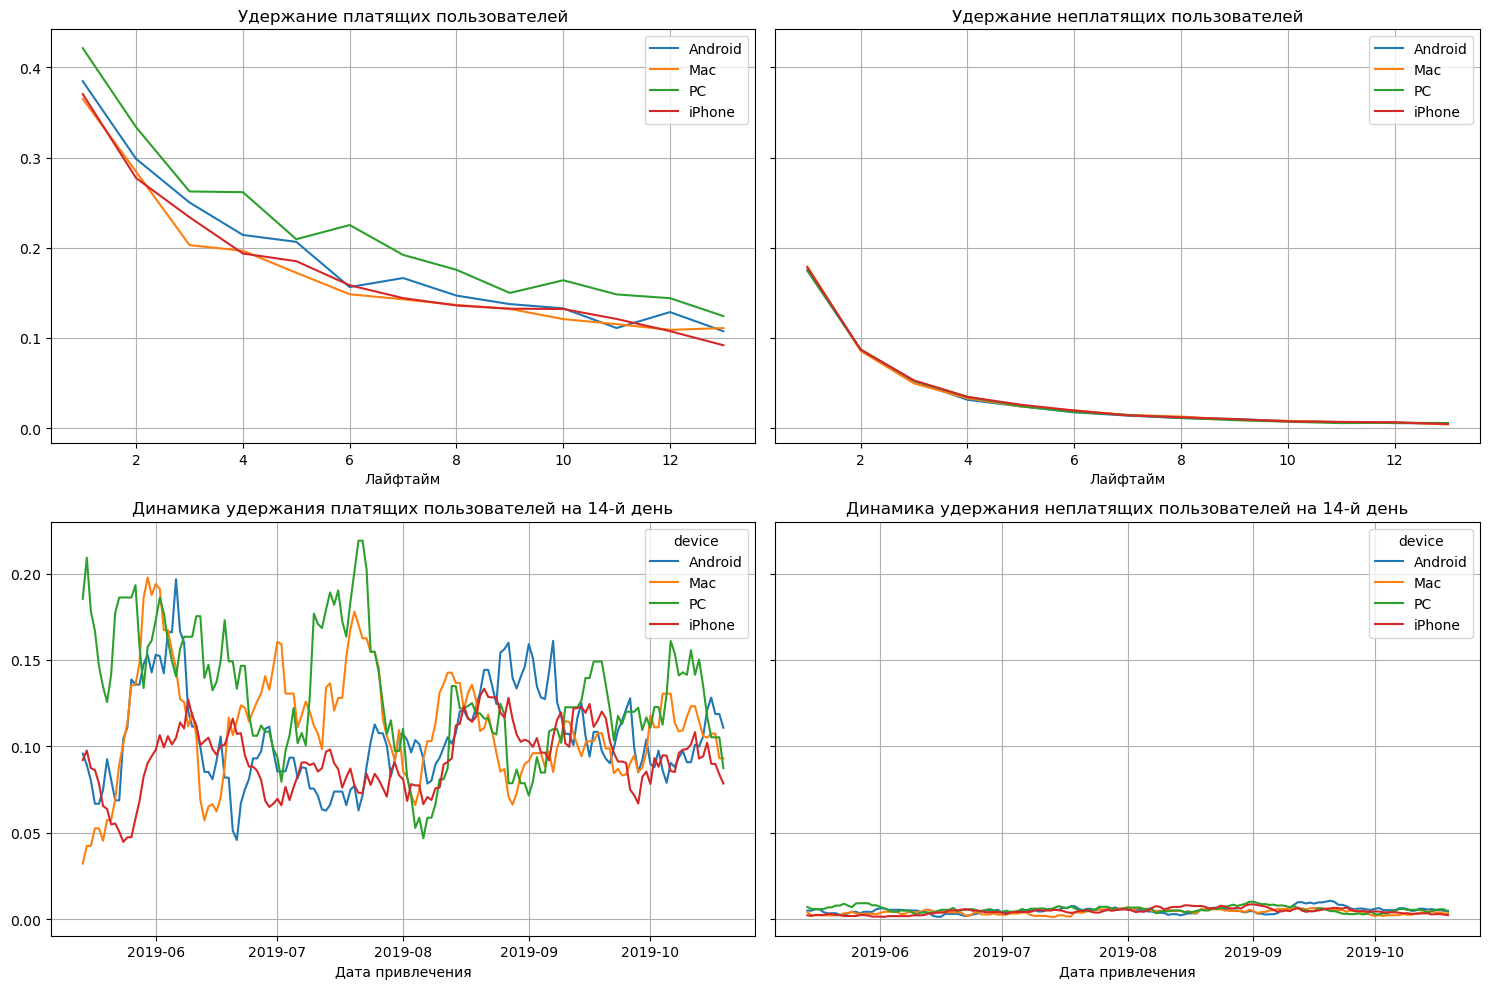

In [101]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days, window=14) 

Здесь мы можем наблюдать достаточно стандартные графики удержания для пользователей всех устройств. Среди неплатящих пользователей удержание, вполне ожидаемо, значительно хуже.

Теперь посчитаем и выведем графики по конверсии и удержанию пользователей с разбивкой по странам:

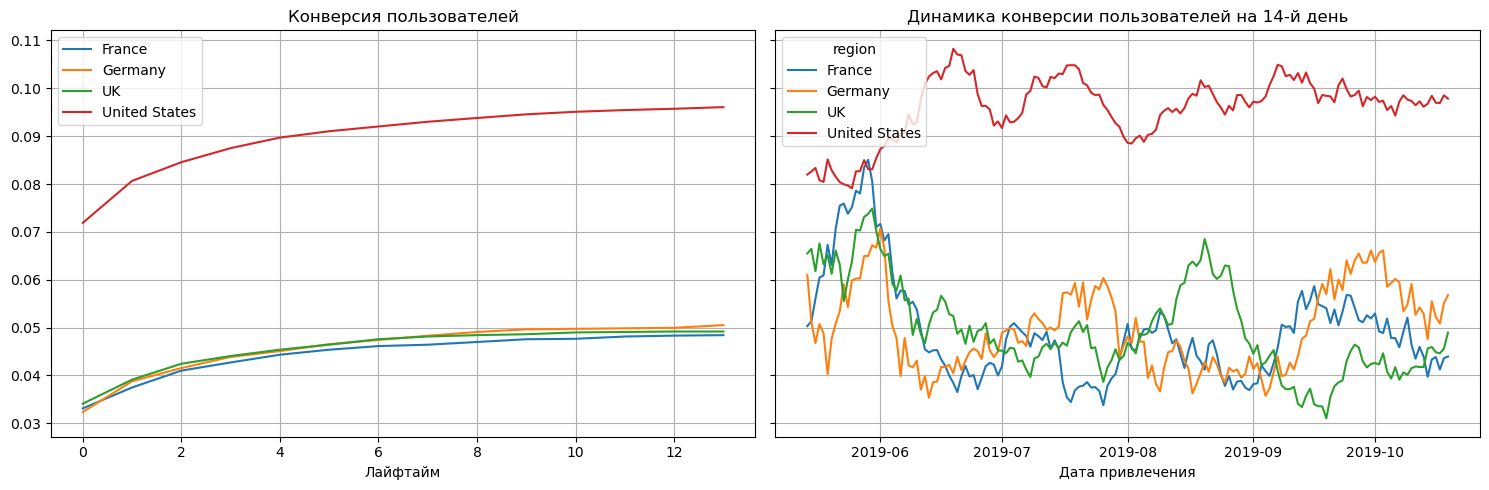

In [102]:
dimensions = ['region']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)
plot_conversion(conversion_grouped, conversion_history, horizon_days, window=14) 

Показатели конверсии пользователей в США самые лучшие.

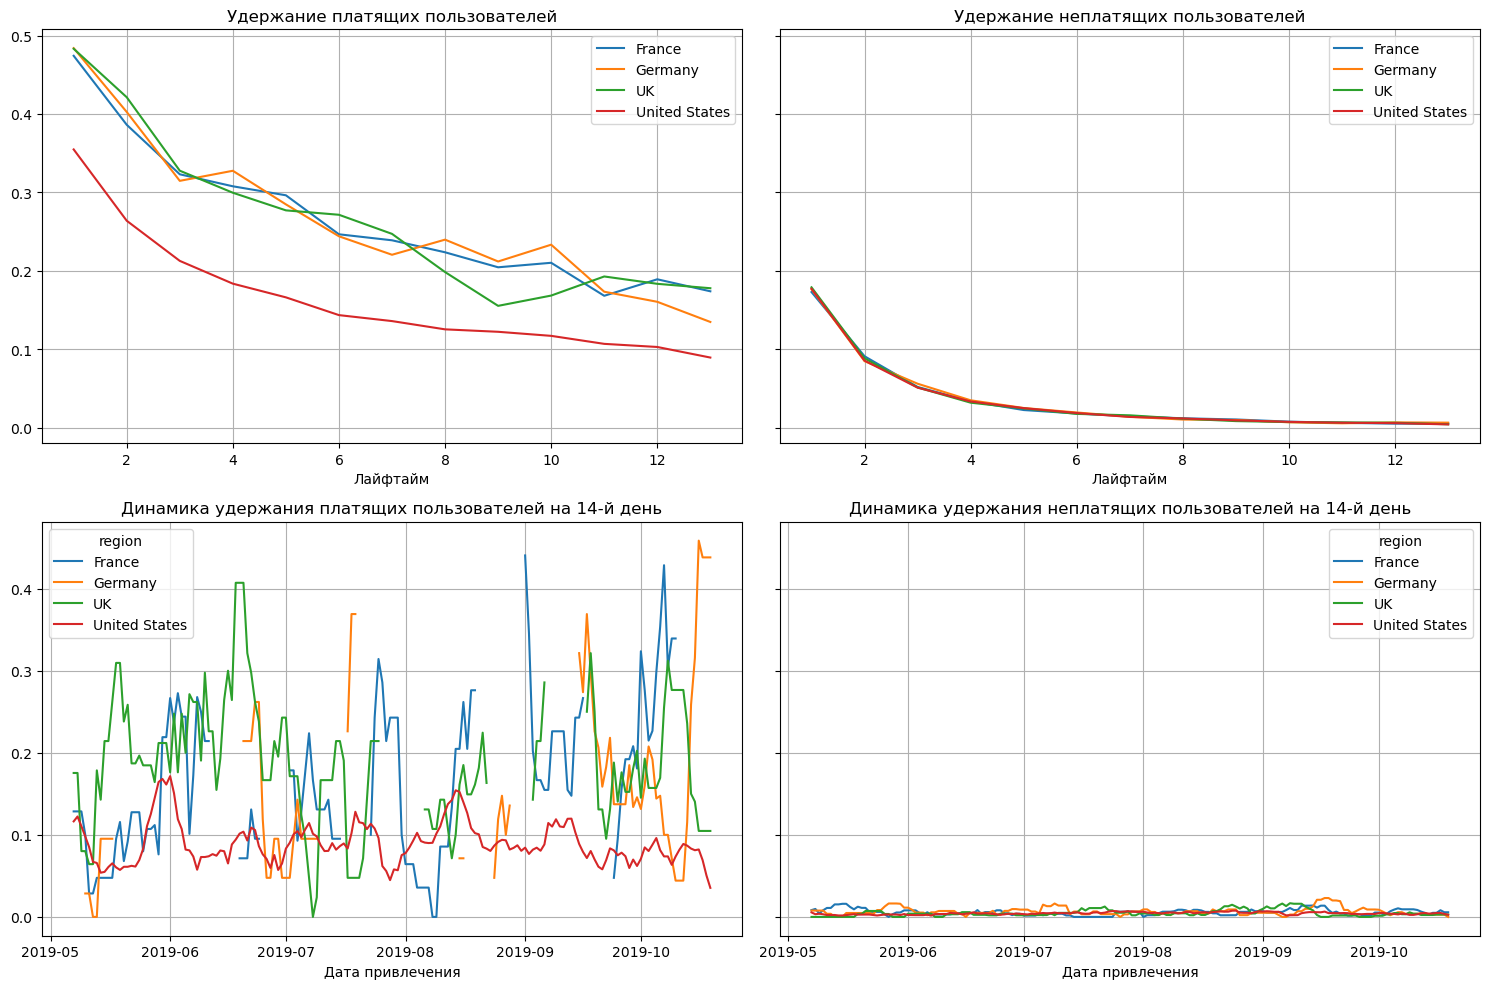

In [103]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)
plot_retention(retention_grouped, retention_history, horizon_days)

Графики удержания здесь также достаточно стандартные, но по удержанию пользователей США отстают.

Теперь посчитаем и выведем графики по конверсии и удержании пользователей с разбивкой по рекламным источникам:

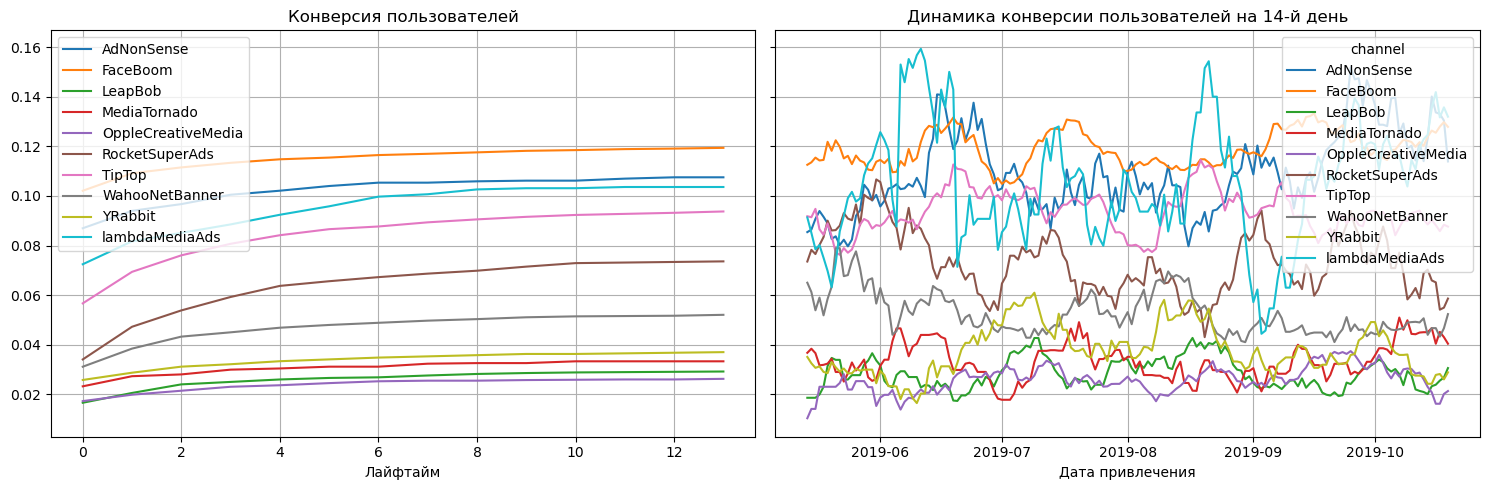

In [104]:
dimensions = ['channel']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)
plot_conversion(conversion_grouped, conversion_history, horizon_days, window=14)

Самая лучшая конверсия у пользователей, пришедших из FaceBoom. 

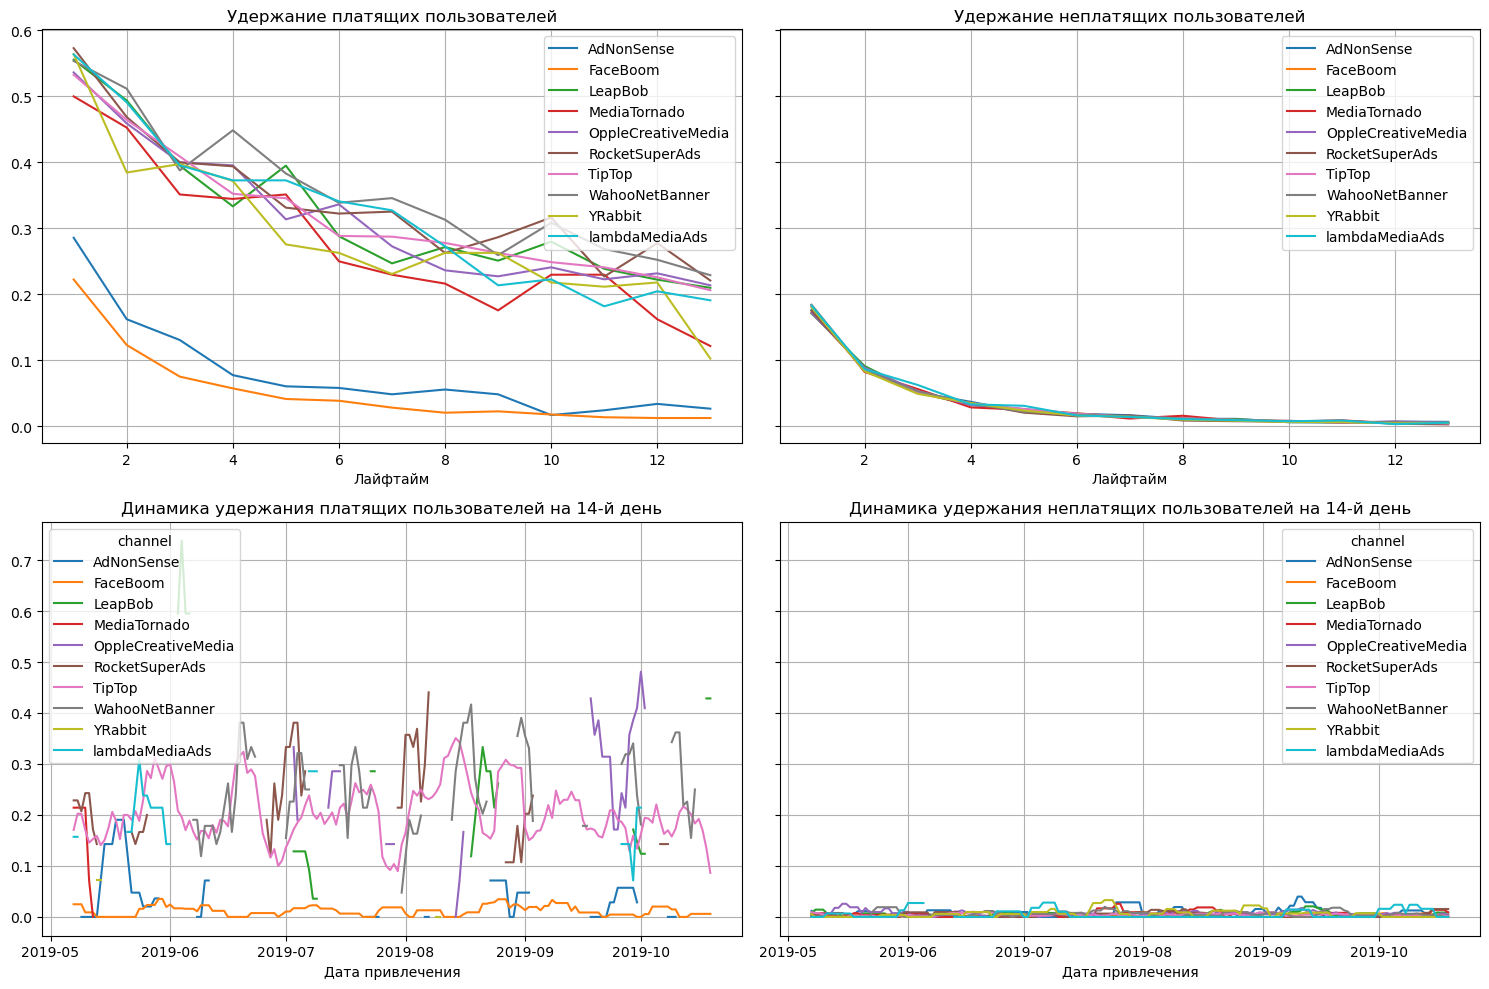

In [105]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)
plot_retention(retention_grouped, retention_history, horizon_days)

Пользователи, пришедшие из рекламных источников FaceBoom и AdNonSense удерживаются хуже всех, причем у платящих пользователей из этих каналов почти такой же плохой результат, как и у неплатящих. 

### 5.6 Вывод и рекомендации для рекламного отдела

LTV пользователей растет, но окупаемость рекламы недостаточная и пролеживается тенденция к ее ухудшению.  Отрицательное влияние оказывают большие затраты на привлечение пользователей Mac и iPhone из США, особенно сильно растут затраты на TipTop, что приводит к его убыточности, при этом удержание пользователей США, пришедших из рекламных каналов FaceBoom и AdNonSense находится на низком уровне. Эти каналы также демонстрируют нам убыточность.  

В качестве решения проблемы окупаемости, рекламному отделу рекомендуется снизить затраты на привлечение пользователей из США, особенно на канал TipTop, и перераспределить их в сторону каналов, приносящих прибыль - YRabbit, lambdaMediaAds, MediaTornado.

## 6 Выводы

**В рамках работы над данным проектом:**

1. Устранены проблемы в данных.
2. Заданы функци, необходимые для проведения расчётов и анализа LTV, ROI, а также удержания и конверсии.
3. Проведен исследовательский анализ, в котором установлено следующее:
- минимальная (01.05.2019) и максимальная (27.10.2019) даты привлечения пользователей;
- наибольшее кол-во пользователей сосредоточено в США, и там же находится наибольшее кол-во платящих пользователей; 
- наибольшее кол-во пользователей используют iPhone, среди платящих пользователей лидируют устройства Mac - 6,36% и iPhone - 6,21%, т.е. продукция Apple (США);
- наибольшее количество пользователей - органические, а лучшая рекламная площадка по привлечению платежеспособных клиентов - FaceBoom - 12,2%. Среди лидеров по привлечению платящих клиентов также можно отметить AdNonSense - 11,34%, lambdaMediaAds - 10,47% и TipTop - 9,6%.
4. При изучении затрат на маркетинг, установлено, что большая часть расходов приходится на два рекламных источника: TipTop и FaceBoom, и эти затраты имеют устойчивую тенденцию к росту. Кроме того выявлено, что TipTop является самым затратным по стоимости привлечения пользователей, его  САС = 2,80 при среднем значении 1,13.
5. При оценке окупаемости рекламы установлено, что LTV пользователей растет, но окупаемость рекламы недостаточная и прослеживается тенденция к ее ухудшению. Причины следующие:
- реклама в США: затраты не окупаются из-за высокого CAC по устройствам MAC и iPhone и высокого CAC каналов привлечения;
- реклама в Европе: не используются популярные рекламные площадки TipTop и FaceBoom, поскольку их Европейская аудитория еще не охвачена, на начальном этапе стоимость привлечения будет значительно ниже, чем в США;
- канал TipTop: высокая и стабильно растущая стоимость привлечения (CAC);
- каналы FaceBoom, AdNonSense: крайне низкие показатели удержания пользователей.


**На основании представленного выше, можно сформулировать следующие рекомендации для отдела маркетинга:**
- рассмотреть варианты привлечения пользователей PC, возможно используя новые рекламные каналы;
- снизить затраты на привлечение пользователей из США на популярные, но уже не эффективные каналы TipTop и FaceBoom;
- увеличить затраты на привлечение пользователей из каналов, приносящих прибыль, для пользователей Европы это канал lambdaMediaAds, для пользователей США - YRabbit,  MediaTornado и RocketSuperAds;
- изучить причины и принять меры для улучшения удержания пользователей из FaceBoom и AdNonSense;
- увеличить рекламную активность, направленную на привлечение пользователей из Европы, где стоимость привлечения пользователей значительно ниже, в т.ч. опробовать привлечение пользователей из популярных каналов TipTop и FaceBoom;
- рассмотреть варианты привлечения пользователей PC, возможно, используя новые рекламные каналы.